<a href="https://colab.research.google.com/github/dookda/cmu_py499/blob/main/gee_meji_usc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install earthengine-api
!pip install geemap folium

# Authenticate and initialize the Earth Engine API
import ee

# Provide your Google Cloud project ID
project_id = 'earthengine-380405'

# Authenticate and initialize the Earth Engine API with the project ID
ee.Authenticate()
ee.Initialize(project=project_id)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
!rm -r '/content/drive/MyDrive/_DATASET/meji_usc.csv'

In [31]:
import ee

ee.Initialize()

# hex150 = ee.FeatureCollection("projects/earthengine-380405/assets/hex150tb_4326");
hexpolygon = ee.FeatureCollection("projects/ee-sakda/assets/hex_usc");
site = hexpolygon.geometry().bounds()


In [93]:
# เมจิ 1

import ee
import folium
import geemap
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_min(img, geom):
    min_val = img.reduceRegion(
        reducer=ee.Reducer.min(),
        geometry=geom,
        scale=100,
        maxPixels=1e9
    ).getInfo()

    print(min_val)
    return min_val['constant']

def get_max(img, geom):
    max_val = img.reduceRegion(
        reducer=ee.Reducer.max(),
        geometry=geom,
        scale=100,
        maxPixels=1e9
    ).getInfo()
    print(max_val)
    return max_val['constant']

def rename_property(feature, params):
    mean_value = feature.get('mean')
    feature = feature.set(params, mean_value)
    feature = feature.set('mean', None)
    return feature

def set_default(feature, params):
    value = ee.Number(feature.get(params))
    return feature.set(params, ee.Algorithms.If(value, value, 0))

def zonal_stat(image, geom, params):
    z_stats = image.reduceRegions(
        collection=geom,
        reducer=ee.Reducer.mean(),
        scale=100,
        tileScale=1,
        crs='EPSG:4326'
    )
    feat = z_stats.map(lambda feature: rename_property(feature, params))
    feat = feat.map(lambda feature: set_default(feature, params))
    return feat

def set_day_of_week(image):
    date = ee.Date(image.get('system:time_start'))
    dayOfWeek = date.getRelative('day', 'week')
    dayName = date.format('EEEE')
    return image.set('day_of_week', dayOfWeek).set('date', date.format('YYYY-MM-dd')).set('day_name', dayName)

def prepare_data(image):
    dateImage = set_day_of_week(image)
    projImage = dateImage.reproject(
        crs="EPSG:32647",
        scale=100
    )
    clipImage = projImage.clip(site)
    return clipImage

def convert_kelvin_to_celsius(image):
    celsius = image.multiply(0.02).subtract(273.15).rename('LST_Celsius')
    return image.addBands(celsius)

def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# cal NDBI
def calculate_ndbi(image):
    ndbi = image.normalizedDifference(['B11', 'B8']).rename('NDBI')
    return image.addBands(ndbi)

# cal NDMI
def calculate_ndmi(image):
    ndmi = image.normalizedDifference(['B8', 'B11']).rename('NDMI')
    return image.addBands(ndmi)

def show_scatter_plot(feat, params):
    scatter_plot = geemap.ee_chart_by_feature(
        ee.FeatureCollection(feat), x_property=params, y_properties=['usc'], chart_type='ScatterChart',
        options={
            'title': 'Scatter Plot of ' + params + ' vs usc',
            'hAxis': {'title': params},
            'vAxis': {'title': 'usc'},
            'pointSize': 5
        }
    )
    scatter_plot.show()

def loadCollectionPre(start_date, end_date):
    O3 = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_O3") \
        .filterBounds(site) \
        .filterDate(start_date, end_date) \
        .select('O3_column_number_density') \
        .map(prepare_data) 

    SO2 = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_SO2") \
        .filterBounds(site) \
        .filterDate(start_date, end_date) \
        .select('SO2_column_number_density') \
        .map(prepare_data) 

    AER_LH = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_AER_LH") \
        .filterBounds(site) \
        .filterDate(start_date, end_date) \
        .select('aerosol_optical_depth') \
        .map(prepare_data) 

    CH4 = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_CH4") \
        .filterBounds(site) \
        .filterDate(start_date, end_date) \
        .select('CH4_column_volume_mixing_ratio_dry_air') \
        .map(prepare_data) 

    HCHO = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_HCHO") \
        .filterBounds(site) \
        .filterDate(start_date, end_date) \
        .select('tropospheric_HCHO_column_number_density') \
        .map(prepare_data) 

    NO2 = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2") \
        .filterBounds(site) \
        .filterDate(start_date, end_date) \
        .select('NO2_column_number_density') \
        .map(prepare_data) 

    CO = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_CO") \
        .filterBounds(site) \
        .filterDate(start_date, end_date) \
        .select('CO_column_number_density') \
        .map(prepare_data) 
    
    # https://pro.arcgis.com/en/pro-app/latest/arcpy/spatial-analyst/an-overview-of-the-spatial-analyst-functions.htm

    # NDVI = ((NIR - Red) / (NIR + Red))
    # NDMI = (NIR - SWIR1)/(NIR + SWIR1)
    # NDBI = (SWIR - NIR) / (SWIR + NIR)
    # B12=SWIR2, B11=SWIR1, B8=NIR, B4=Red, B3=Green, B2=Blue

    NDVI = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
        .filterBounds(site) \
        .filterDate(start_date, end_date) \
        .map(calculate_ndvi) \
        .map(prepare_data) \
        .select('NDVI')
    
    NDBI = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
        .filterBounds(site) \
        .filterDate(start_date, end_date) \
        .map(calculate_ndbi) \
        .map(prepare_data) \
        .select('NDBI')
    
    NDMI = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
        .filterBounds(site) \
        .filterDate(start_date, end_date) \
        .map(calculate_ndmi) \
        .map(prepare_data) \
        .select('NDMI')

    LST = ee.ImageCollection("MODIS/061/MOD11A1") \
        .filterBounds(site) \
        .filterDate(start_date, end_date) \
        .select('LST_Day_1km') \
        .map(convert_kelvin_to_celsius) \
        .map(prepare_data) \
        .select('LST_Celsius') 
    
    return O3, SO2, AER_LH, CH4, HCHO, NO2, CO, NDVI, NDBI, NDMI, LST

def loadCollectionMedian(start_date, end_date):
    O3, SO2, AER_LH, CH4, HCHO, NO2, CO, NDVI, NDBI, NDMI, LST = loadCollectionPre(start_date, end_date)
    o3 = O3.median()
    so2 = SO2.median()
    aer_lh = AER_LH.median()
    ch4 = CH4.median()
    hcho = HCHO.median()
    no2 = NO2.median()
    co = CO.median()
    ndvi = NDVI.median()
    ndbi = NDBI.median()
    ndmi = NDMI.median()
    lst = LST.median()
    return o3, so2, aer_lh, ch4, hcho, no2, co, ndvi, ndbi, ndmi, lst

def loadCollectionMean(start_date, end_date):
    O3, SO2, AER_LH, CH4, HCHO, NO2, CO, NDVI, NDBI, NDMI, LST = loadCollectionPre(start_date, end_date)
    o3 = O3.mean()
    so2 = SO2.mean()
    aer_lh = AER_LH.mean()
    ch4 = CH4.mean()
    hcho = HCHO.mean()
    no2 = NO2.mean()
    co = CO.mean()
    ndvi = NDVI.mean()
    ndbi = NDBI.mean()
    ndmi = NDMI.mean()
    lst = LST.mean()
    return o3, so2, aer_lh, ch4, hcho, no2, co, ndvi, ndbi, ndmi, lst

def getImageCollectionDayMedian(collection,params):
    print(f"{collection.size().getInfo()} {params}")
    monImages = collection.filter(ee.Filter.eq('day_of_week', 0)).median()
    tueImages = collection.filter(ee.Filter.eq('day_of_week', 1)).median()
    wedImages = collection.filter(ee.Filter.eq('day_of_week', 2)).median()
    thuImages = collection.filter(ee.Filter.eq('day_of_week', 3)).median()
    friImages = collection.filter(ee.Filter.eq('day_of_week', 4)).median()
    satImages = collection.filter(ee.Filter.eq('day_of_week', 5)).median()
    sunImages = collection.filter(ee.Filter.eq('day_of_week', 6)).median()

    mon = zonal_stat(monImages, hexpolygon, params+'mon')
    tue = zonal_stat(tueImages, mon, params+'tue')
    wed = zonal_stat(wedImages, tue, params+'wed')
    thu = zonal_stat(thuImages, wed, params+'thu')
    fri = zonal_stat(friImages, thu, params+'fri')
    sat = zonal_stat(satImages, fri, params+'sat')
    sun = zonal_stat(sunImages, sat, params+'sun')

    return sun

def getImageCollectionDayMean(collection,params):
    print(f"{collection.size().getInfo()} {params}")
    monImages = collection.filter(ee.Filter.eq('day_of_week', 0)).mean()
    tueImages = collection.filter(ee.Filter.eq('day_of_week', 1)).mean()
    wedImages = collection.filter(ee.Filter.eq('day_of_week', 2)).mean()
    thuImages = collection.filter(ee.Filter.eq('day_of_week', 3)).mean()
    friImages = collection.filter(ee.Filter.eq('day_of_week', 4)).mean()
    satImages = collection.filter(ee.Filter.eq('day_of_week', 5)).mean()
    sunImages = collection.filter(ee.Filter.eq('day_of_week', 6)).mean()

    mon = zonal_stat(monImages, hexpolygon, params+'mon')
    tue = zonal_stat(tueImages, mon, params+'tue')
    wed = zonal_stat(wedImages, tue, params+'wed')
    thu = zonal_stat(thuImages, wed, params+'thu')
    fri = zonal_stat(friImages, thu, params+'fri')
    sat = zonal_stat(satImages, fri, params+'sat')
    sun = zonal_stat(sunImages, sat, params+'sun')

    return sun

# get week from date
def get_week(date= '2021-01-01'):
    date = ee.Date(date)
    return date.get('week')

# get date range from week
def get_date_range(week=1, year=2021):
    start_date = ee.Date.fromYMD(year, 1, 1)
    start_date = start_date.advance(week, 'week')
    end_date = start_date.advance(1, 'week')
    return start_date, end_date

def export_img_to_drive(image, name, folder, scale=100):
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=name,
        folder=folder,
        fileNamePrefix=name,
        scale=scale,
        region=site
    )
    task.start()

def export_csv_to_drive(feature_collection, param_name, folder):
    task = ee.batch.Export.table.toDrive(
        collection=feature_collection,
        description=param_name,
        folder=folder,
        fileNamePrefix=param_name,
        fileFormat='CSV'
    )
    task.start()

def corr_chart():
    dir = '/Users/sakdahomhuan/Library/CloudStorage/GoogleDrive-sakda.homhuan@gmail.com/My Drive/'
    listfile = os.path.join(dir, '_GEE')
    for file in os.listdir(listfile):
        df = pd.read_csv(os.path.join(listfile, file))
        # print(df.head())
        columns_of_interest = ['aer_lh', 'bd_h', 'ch4', 'co', 'hcho', 'lst',
                        'no2', 'o3', 'road_w','so2', 'usc', 'ndvi']

        correlation_matrix = df[columns_of_interest].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Matrix')
        # plt.show()

        chart_name = file.replace('.csv', '.png')
        print(chart_name)
        output_dir = os.path.join(listfile, 'chart')
        plt.savefig(os.path.join(output_dir, chart_name))

In [94]:
start_date = '2021-11-01'
end_date = '2022-04-30' 

O3, SO2, AER_LH, CH4, HCHO, NO2, CO, NDVI, NDBI, NDMI, LST = loadCollectionPre(start_date, end_date)

In [95]:
print(LST.first().getInfo())

{'type': 'Image', 'bands': [{'id': 'LST_Celsius', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': -273.15, 'max': 1037.5500000000002}, 'dimensions': [166, 177], 'origin': [4916, -20868], 'crs': 'EPSG:32647', 'crs_transform': [100, 0, 0, 0, -100, 0]}], 'version': 1658130408058844, 'id': 'MODIS/061/MOD11A1/2021_11_01', 'properties': {'date': '2021-11-01', 'day_name': 'Monday', 'system:footprint': {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[98.92145131982353, 18.713941886258606], [99.07647202171762, 18.713941886258606], [99.07647202171762, 18.872106282744014], [98.92145131982353, 18.872106282744014], [98.92145131982353, 18.713941886258606]]]}, 'day_of_week': 0, 'system:time_start': 1635724800000, 'google:max_source_file_timestamp': 1636499267000, 'system:time_end': 1635811200000, 'system:asset_size': 764764096, 'system:index': '2021_11_01'}}


In [96]:
# เมจิ 2
# ทำ Zonal stat แบบรายวัน

start_date = '2021-11-01'
end_date = '2022-04-30' 

O3, SO2, AER_LH, CH4, HCHO, NO2, CO, NDVI, NDBI, NDMI, LST = loadCollectionPre(start_date, end_date)

featureO3 = getImageCollectionDayMean(O3, 'o3').select(['id', 'usc', 'o3mon', 'o3tue', 'o3wed', 'o3thu', 'o3fri', 'o3sat', 'o3sun'])
featureSO2 = getImageCollectionDayMean(SO2, 'so2').select(['id', 'usc', 'so2mon', 'so2tue', 'so2wed', 'so2thu', 'so2fri', 'so2sat', 'so2sun'])
featureAER_LH = getImageCollectionDayMean(AER_LH, 'aer_lh').select(['id', 'usc', 'aer_lhmon', 'aer_lhtue', 'aer_lhwed', 'aer_lhthu', 'aer_lhfri', 'aer_lhsat', 'aer_lhsun'])
featureCH4 = getImageCollectionDayMean(CH4, 'ch4').select(['id', 'usc', 'ch4mon', 'ch4tue', 'ch4wed', 'ch4thu', 'ch4fri', 'ch4sat', 'ch4sun'])
featureHCHO = getImageCollectionDayMean(HCHO, 'hcho').select(['id', 'usc', 'hchomon', 'hchotue', 'hchowed', 'hchothu', 'hchofri', 'hchosat', 'hchosun'])
featureNO2 = getImageCollectionDayMean(NO2, 'no2').select(['id', 'usc', 'no2mon', 'no2tue', 'no2wed', 'no2thu', 'no2fri', 'no2sat', 'no2sun'])
featureCO = getImageCollectionDayMean(CO, 'co').select(['id', 'usc', 'comon', 'cotue', 'cowed', 'cothu', 'cofri', 'cosat', 'cosun'])
featureNDVI = getImageCollectionDayMean(NDVI, 'ndvi').select(['id', 'usc', 'ndvimon', 'ndvitue', 'ndviwed', 'ndvithu', 'ndvifri', 'ndvisat', 'ndvisun'])
featureNDBI = getImageCollectionDayMean(NDBI, 'ndbi').select(['id', 'usc', 'ndbimon', 'ndbitue', 'ndbiwed', 'ndbithu', 'ndbifri', 'ndbisat', 'ndbisun'])
featureNDMI = getImageCollectionDayMean(NDMI, 'ndmi').select(['id', 'usc', 'ndmimon', 'ndmitue', 'ndmiwed', 'ndmithu', 'ndmifri', 'ndmisat', 'ndmisun'])
featureLST = getImageCollectionDayMean(LST, 'lst').select(['id', 'usc', 'lstmon', 'lsttue', 'lstwed', 'lstthu', 'lstfri', 'lstsat', 'lstsun'])

export_csv_to_drive(feature_collection=featureO3, param_name='usc_o3', folder='_GEE')
export_csv_to_drive(feature_collection=featureSO2, param_name='usc_so2', folder='_GEE')
export_csv_to_drive(feature_collection=featureAER_LH, param_name='usc_aer_lh', folder='_GEE')
export_csv_to_drive(feature_collection=featureCH4, param_name='usc_ch4', folder='_GEE')
export_csv_to_drive(feature_collection=featureHCHO, param_name='usc_hcho', folder='_GEE')
export_csv_to_drive(feature_collection=featureNO2, param_name='usc_no2', folder='_GEE')
export_csv_to_drive(feature_collection=featureCO, param_name='usc_co', folder='_GEE')
export_csv_to_drive(feature_collection=featureNDVI, param_name='usc_ndvi', folder='_GEE')
export_csv_to_drive(feature_collection=featureNDBI, param_name='usc_ndbi', folder='_GEE')
export_csv_to_drive(feature_collection=featureNDMI, param_name='usc_ndmi', folder='_GEE')
export_csv_to_drive(feature_collection=featureLST, param_name='usc_lst', folder='_GEE')

print('เมจิลองดูในโฟลเดอร์ _GEE ใน Google Drive นะครับ')


2543 o3
2537 so2
2537 aer_lh
2534 ch4
2537 hcho
2541 no2
2541 co
70 ndvi
70 ndbi
70 ndmi
180 lst
เมจิลองดูในโฟลเดอร์ _GEE ใน Google Drive นะครับ


In [ ]:
# show NDVI info
# print(NDVI.first().getInfo())
print(NDVI.first().getInfo())


/Users/sakdahomhuan/Library/CloudStorage/GoogleDrive-sakda.homhuan@gmail.com/My Drive/_GEE


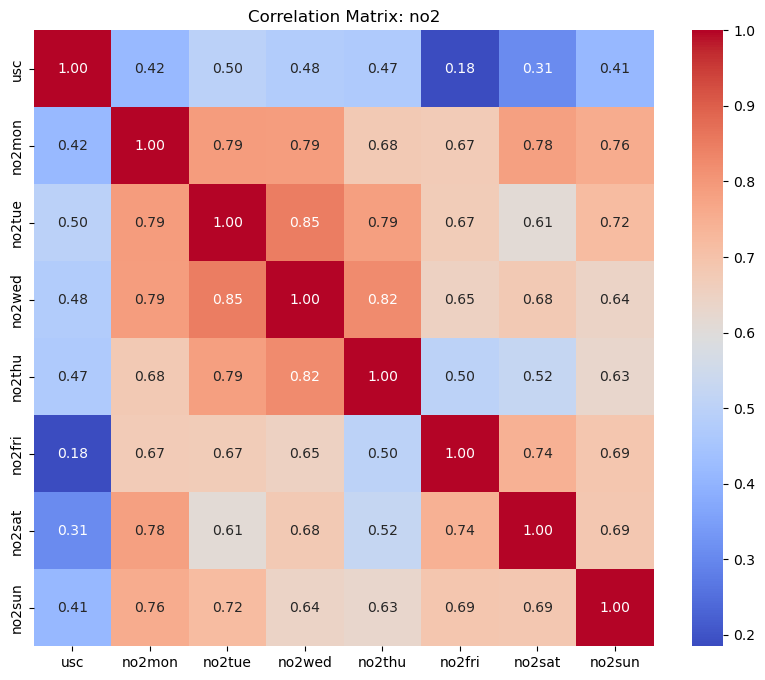

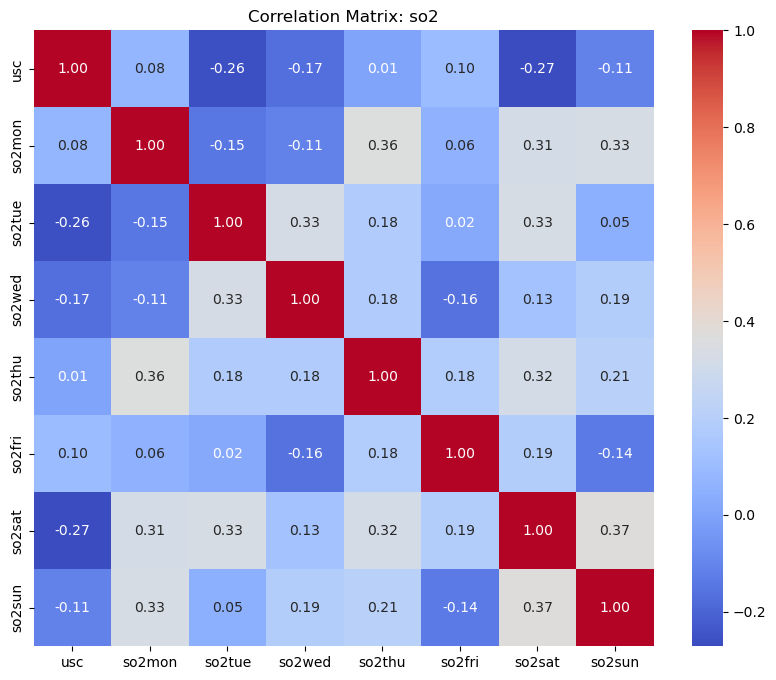

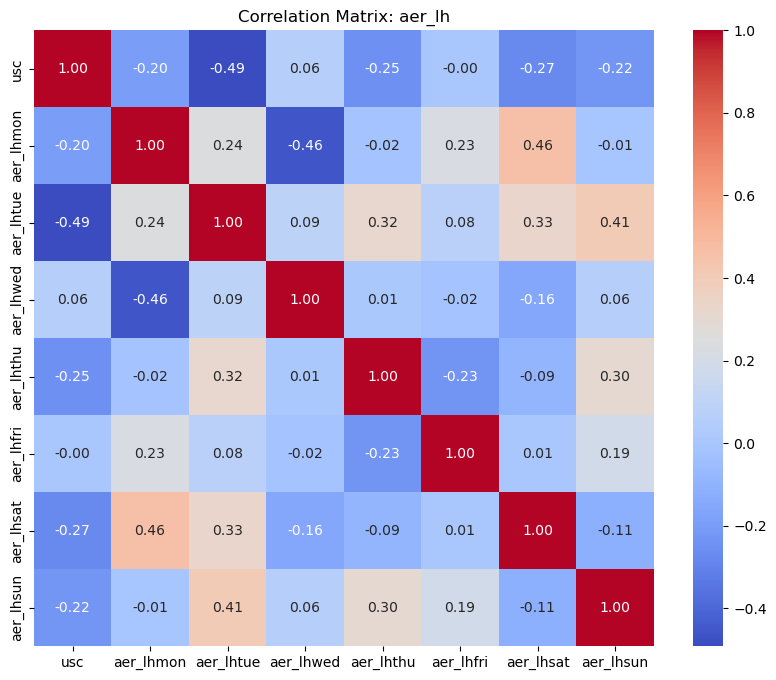

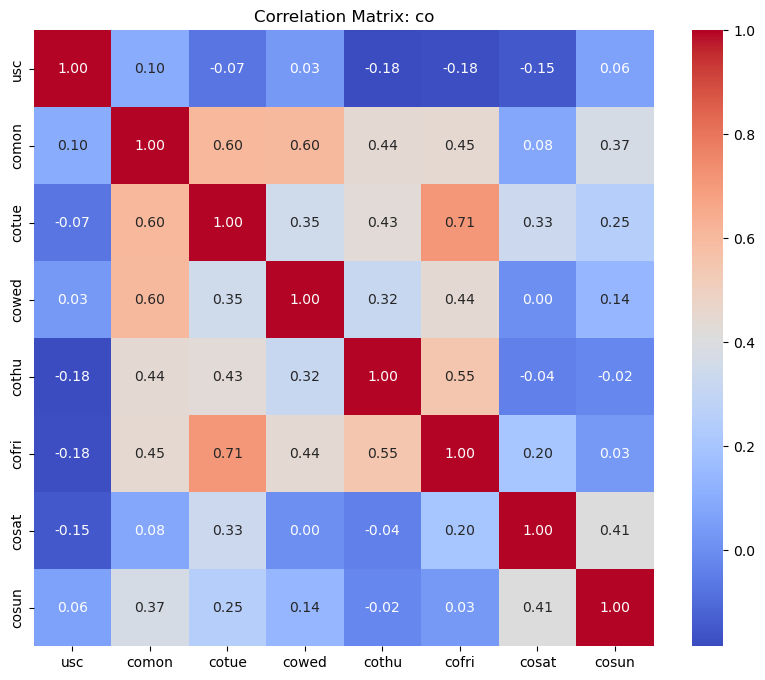

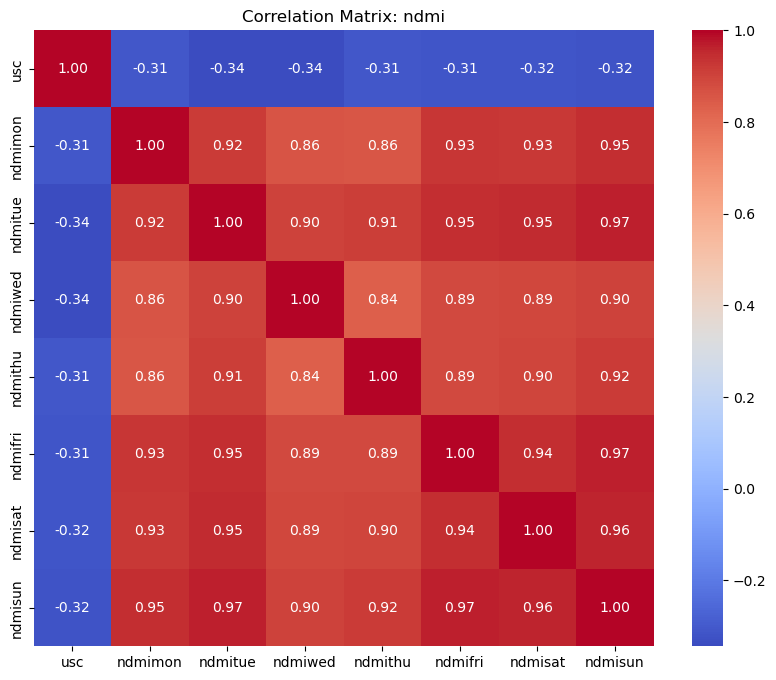

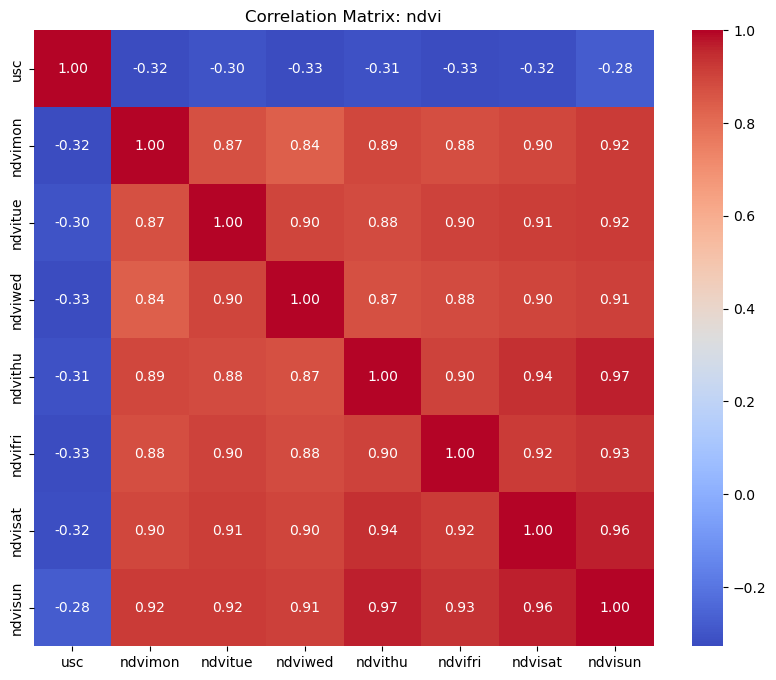

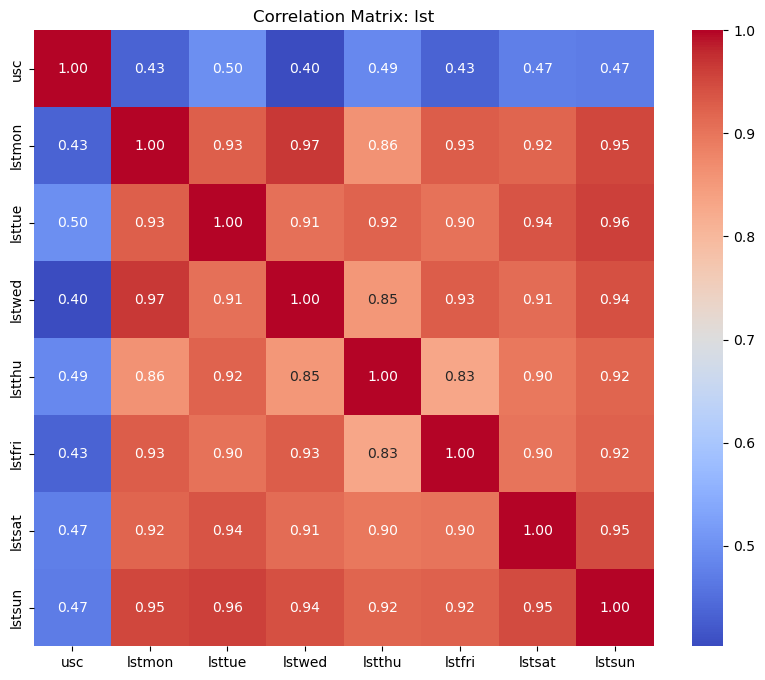

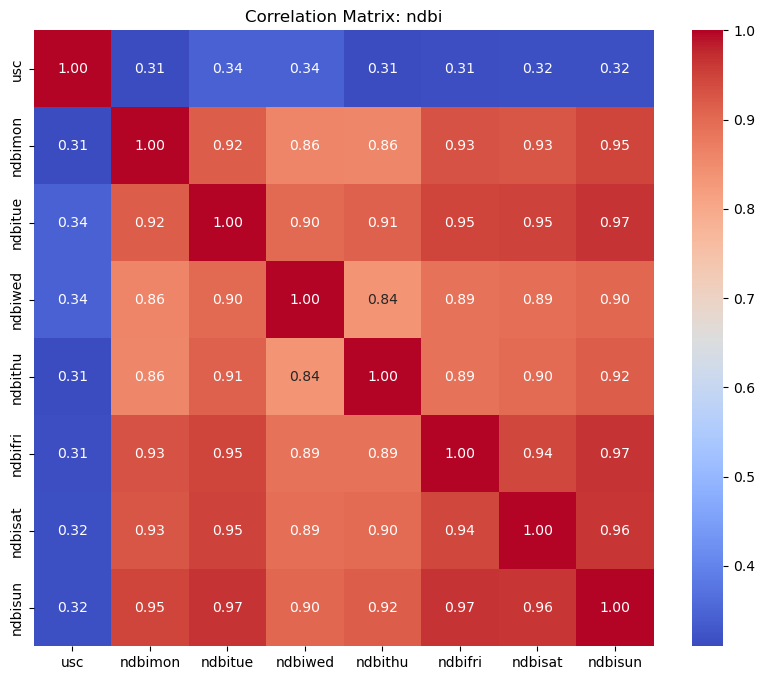

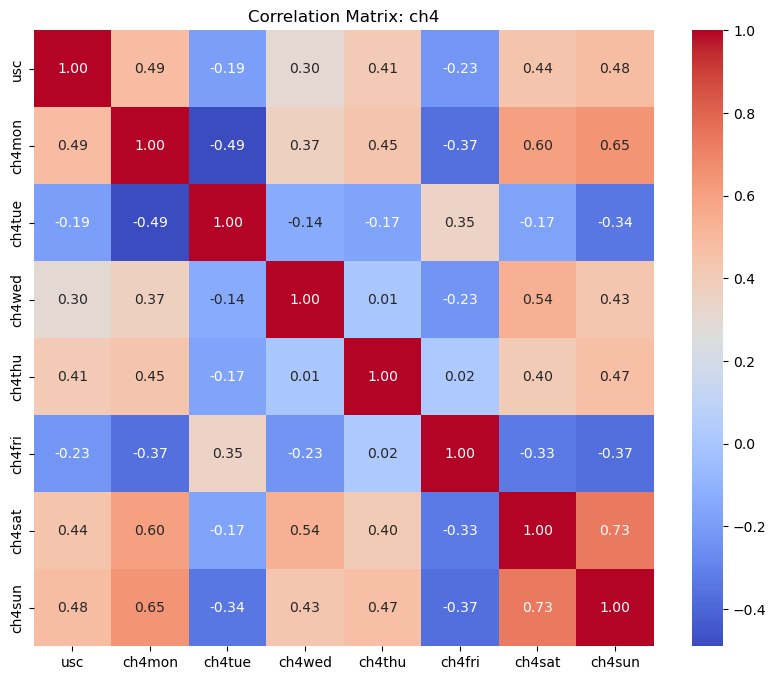

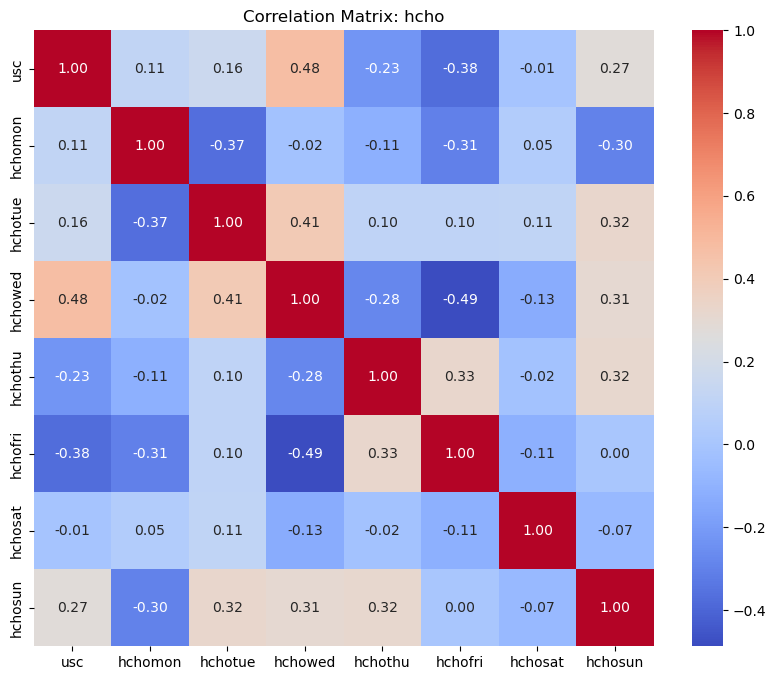

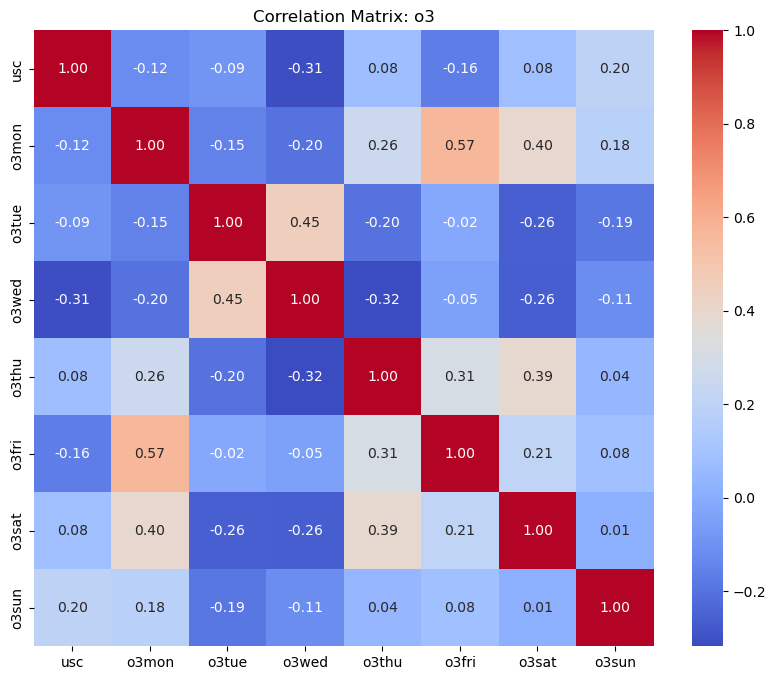

In [97]:
# เมจิ 3 แสดงผล Correlation Matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dir = '/Users/sakdahomhuan/Library/CloudStorage/GoogleDrive-sakda.homhuan@gmail.com/My Drive/'
listfile = os.path.join(dir, '_GEE')

print(listfile)

for file in os.listdir(listfile):
    if not file.endswith('.csv'):
        continue
    
    fname = file.replace('.csv', '').replace('usc_', '')
    df = pd.read_csv(os.path.join(listfile,file))
    columns_of_interest = ['usc', fname+'mon', fname+'tue', fname+'wed', fname+'thu', fname+'fri', fname+'sat', fname+'sun']
    correlation_matrix = df[columns_of_interest].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix: '+fname)
    plt.show()

In [ ]:
# วิเคราะห์ความสัมพันธ์ของข้อมูล แบบ mon-sun
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dir = '/Users/sakdahomhuan/Library/CloudStorage/GoogleDrive-sakda.homhuan@gmail.com/My Drive/'
listfile = os.path.join(dir, '_GEE')

for file in os.listdir(listfile):
    if not file.endswith('.csv'):
        continue

    df = pd.read_csv(os.path.join(listfile, file))
    columns_of_interest = ['usc', 'co', 'no2', 'o3', 'so2', 'lst', 'ndbi', 'ndmi','ndvi']
    # print(df.head())
    # print(df[columns_of_interest].head())

    f_name = file.split('.')
    correlation_matrix = df[columns_of_interest].corr()
    
    usc_record = correlation_matrix[:1]
    usc_record['file_name'] = f_name[0]
    csv_path = os.path.join(listfile, 'correlation_data.txt')
    if os.path.exists(csv_path):
        usc_record.to_csv(csv_path, mode='a', header=False, index=False)
    else:
        usc_record.to_csv(csv_path, index=False)


    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix ' + str(f_name[0]))
    plt.show()

    output_dir = os.path.join(listfile, 'chart')
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    chart_name = f_name[0] + '.png'
    chart_path = os.path.join(output_dir, chart_name)

    if os.path.exists(chart_path):
        os.remove(chart_path)
    plt.savefig(chart_path)
    plt.close()

    print('saved ' + chart_name)


In [ ]:
# ทำ Zonal stat แบบรายสัปดาห์
week = range(1, 53)
year = 2021

for w in week:
    try:
        start_date, end_date = get_date_range(w, year)
        print(w, start_date.format('YYYY-MM-dd').getInfo(), end_date.format('YYYY-MM-dd').getInfo())

        O3, SO2, AER_LH, CH4, HCHO, NO2, CO, NDVI, NDBI, NDMI, LST = loadCollectionMedian(start_date, end_date)

        lst = zonal_stat(LST, hexpolygon, 'lst')
        ndvi = zonal_stat(NDVI, lst, 'ndvi')
        o3 = zonal_stat(O3, ndvi, 'o3')
        so2 = zonal_stat(SO2, o3, 'so2')
        aer_lh = zonal_stat(AER_LH, so2, 'aer_lh')
        ch4 = zonal_stat(CH4, aer_lh, 'ch4')
        hcho = zonal_stat(HCHO, ch4, 'hcho')
        co = zonal_stat(CO, hcho, 'co')
        ndbi = zonal_stat(NDBI, co, 'ndbi')
        ndmi = zonal_stat(NDMI, ndbi, 'ndmi')
        no2 = zonal_stat(NO2, ndmi, 'no2')

        export_csv_to_drive(feature_collection=no2, param_name='usc_'+str(w)+'_'+str(year), folder='_GEE/median2022')
    except Exception as e:
        print(f"An error occurred in week {w}: {e}")


In [ ]:
# วิเคราะห์ความสัมพันธ์ แบบง่ายๆ สัปดาห์เดียว
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_path = '/content/drive/MyDrive/_DATASET/meji_usc.csv'

df = pd.read_csv(file_path)
print(df.columns)

columns_of_interest = ['aer_lh', 'bd_h', 'ch4', 'co', 'hcho', 'lst',
                       'no2', 'o3', 'road_w','so2', 'usc', 'ndvi']

correlation_matrix = df[columns_of_interest].corr()
print(correlation_matrix)
# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# วิเคราะห์ความสัมพันธ์ของข้อมูล ลูปทุกสัปดาห์
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dir = '/Users/sakdahomhuan/Library/CloudStorage/GoogleDrive-sakda.homhuan@gmail.com/My Drive/'
listfile = os.path.join(dir, '_GEE')

for file in os.listdir(listfile):
    if not file.endswith('.csv'):
        continue

    df = pd.read_csv(os.path.join(listfile, file))
    columns_of_interest = ['usc', 'co', 'no2', 'o3', 'so2', 'lst', 'ndbi', 'ndmi','ndvi']
    # print(df.head())
    # print(df[columns_of_interest].head())

    f_name = file.split('.')
    correlation_matrix = df[columns_of_interest].corr()
    
    usc_record = correlation_matrix[:1]
    usc_record['file_name'] = f_name[0]
    csv_path = os.path.join(listfile, 'correlation_data.txt')
    if os.path.exists(csv_path):
        usc_record.to_csv(csv_path, mode='a', header=False, index=False)
    else:
        usc_record.to_csv(csv_path, index=False)


    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix ' + str(f_name[0]))
    plt.show()

    output_dir = os.path.join(listfile, 'chart')
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    chart_name = f_name[0] + '.png'
    chart_path = os.path.join(output_dir, chart_name)

    if os.path.exists(chart_path):
        os.remove(chart_path)
    plt.savefig(chart_path)
    plt.close()

    print('saved ' + chart_name)


In [68]:
start_date = '2024-01-01'
end_date = '2024-01-15'

O3, SO2, AER_LH, CH4, HCHO, NO2, CO, NDVI, NDBI, NDMI, LST = loadCollectionMedian(start_date, end_date)

lst = zonal_stat(LST, hexpolygon, 'lst')
ndvi = zonal_stat(NDVI, lst, 'ndvi')
o3 = zonal_stat(O3, ndvi, 'o3')
so2 = zonal_stat(SO2, o3, 'so2')
co = zonal_stat(CO, so2, 'co')
no2 = zonal_stat(NO2, co, 'no2')

# Create map
map_center = [18.80, 99]
f = folium.Figure(height=400)
m = folium.Map(location=map_center, zoom_start=12).add_to(f)

google_satellite = folium.TileLayer(
    tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google',
    name='Google Satellite',
    overlay=False,
    control=True
).add_to(m)

def showMap(feat, geom, param):
  empty = ee.Image().byte()
  imageUsc = empty.paint( featureCollection=feat, color=param)
  visualization = {
      'min': get_min(imageUsc, geom),
      'max': get_max(imageUsc, geom),
      'palette': ['green', 'yellow', 'red']
  }

  map_id_dict = ee.Image(imageUsc).getMapId(visualization)
  folium.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=param,
      overlay=True,
      control=True,
      opacity=0.5
  ).add_to(m)

showMap(co, site, 'usc')
showMap(no2, site, 'no2')
showMap(ndvi, site, 'ndvi')
showMap(lst, site, 'lst')
showMap(o3, site, 'o3')

folium.LayerControl().add_to(m)
m

{'constant': 0}
{'constant': 6.124}
{'constant': 0}
{'constant': 0}
{'constant': 0}
{'constant': 0}
{'constant': 25}
{'constant': 31}
{'constant': 0}
{'constant': 0}


In [ ]:
# วิเคราะห์ MLR

import os
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# drive.mount('/content/drive')
dir = '/Users/sakdahomhuan/Library/CloudStorage/GoogleDrive-sakda.homhuan@gmail.com/My Drive/'
file_path = os.path.join(dir, '_GEE')

for file in os.listdir(file_path):
    if not file.endswith('.csv'):
        continue

    df = pd.read_csv(os.path.join(file_path, file))
    df = df.dropna(subset=['usc'])

    if df.shape[0] == 0:
        raise ValueError("No samples available after dropping rows with null values.")

    target_variable = 'co'
    columns_of_interest = ['usc', 'ndvi', 'ndbi', 'ndmi', 'lst']

    X = df[columns_of_interest]
    y = df[target_variable]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Forward stepwise regression
    def forward_stepwise_selection(X, y):
        initial_features = []
        remaining_features = list(X.columns)
        best_features = []
        while remaining_features:
            scores_with_candidates = []
            for candidate in remaining_features:
                features = initial_features + [candidate]
                X_train_with_candidate = sm.add_constant(X[features])
                model = sm.OLS(y, X_train_with_candidate).fit()
                score = model.rsquared_adj
                scores_with_candidates.append((score, candidate))
            scores_with_candidates.sort(reverse=True)
            best_new_score, best_candidate = scores_with_candidates[0]
            if initial_features:
                best_old_score = sm.OLS(y, sm.add_constant(X[initial_features])).fit().rsquared_adj
                if best_new_score <= best_old_score:
                    break
            initial_features.append(best_candidate)
            remaining_features.remove(best_candidate)
            best_features.append((best_new_score, best_candidate))
        return best_features

    best_features = forward_stepwise_selection(X_train, y_train)

    # print("Selected features and their adjusted R-squared scores:")
    # for score, feature in best_features:
    #     print(f"{feature}: {score}")

    selected_features = [feature for _, feature in best_features]
    X_train_selected = sm.add_constant(X_train[selected_features])
    X_test_selected = sm.add_constant(X_test[selected_features])
    final_model = sm.OLS(y_train, X_train_selected).fit()

    # print(final_model.summary())

    y_pred = final_model.predict(X_test_selected)
    print(f"R-squared in test set: {final_model.rsquared:.3f} of {file}")
    
